In [29]:
import os, sys
import time
import datetime
import pandas as pd
import numpy as np
import math
from math import radians, cos, sin, asin, sqrt 
import random


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Ellipse, Circle

ROOTDIR = os.path.abspath(os.path.realpath('./')) + '/Py'

sys.path.append(os.path.join(ROOTDIR, ''))

import dgckernel

import geopandas as gp
import shapely



# Class

In [30]:
class Stamp_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_date(self,stamp):
        dateArray = datetime.datetime.fromtimestamp(stamp)
        otherStyleTime = dateArray.strftime("%Y-%m-%d %H:%M:%S")
        return otherStyleTime[:10]
    
    '''Time stamp'''
    def Get_stamp(self,time_str):
        timeArray = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
        timeStamp = int(time.mktime(timeArray))
        return timeStamp
    
    '''Time step'''
    def Get_step(self,stamp,date_str,step):
        baseline = date_str+" 00:00:00";
        baseline = int(self.Get_stamp(baseline))
        current_step=int((stamp-baseline)/step)
        return current_step
    
    def Get_datelist(self, beginDate, endDate):
        date_list=[datetime.datetime.strftime(x,'%Y-%m-%d') for x in list(pd.date_range(start=beginDate, end=endDate))]
        return date_list
    
    def Get_weekday(self,date_str):
        date_str = date_str+" 00:00:00";
        date_str = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return date_str.tm_wday+1

    def Get_normalization(self,end_step,t_step):
        if t_step>=end_step:
            return t_step-end_step
        else:
            return t_step
        
class Polygon_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_PolyCoords(self, Geo_Obj):

        if Geo_Obj.type=='Polygon':

            return list(Geo_Obj.exterior.coords)

        elif Geo_Obj.type=='MultiPolygon':
            
            boundary=list()
            
            for polygon in Geo_Obj:
                
                boundary+=list(polygon.exterior.coords)
                
            return boundary
        
    def Get_intersect(self, polygon1,polygon2):
        
        intersect=list(set(polygon1).intersection(set(polygon2)))
        
        if len(intersect)!=0:
            
            return True
        
        else:
            return False   

In [93]:
class Graph :

    def __init__(self,Distance_matrix) :
        self.node_count = len(Distance_matrix) 
        self.Distance_matrix=Distance_matrix

    def Dijkstra(self,source,sink) :

        '''Initialize the distance of all the nodes from source to infinity'''
        distance = [float('inf')] * self.node_count
        distance[source] = 0.0

        '''Create a dictionary of {node, distance_from_source}'''
        Distance_dic = {source: 0}

        while Distance_dic:

            '''Get the key for the smallest value in the dictionary'''
            source_node = min(Distance_dic, key = lambda k: Distance_dic[k])
            
            del Distance_dic[source_node]
            
            con=(Distance_matrix[source_node]!=float('inf'))&(Distance_matrix[source_node]!=0.0)

            for node in np.argwhere(con).flatten():
                
                dist=Distance_matrix[source_node][node]

                '''Edge relaxation'''
                if distance[node] > distance[source_node] + dist :
                    distance[node] = distance[source_node] + dist
                    Distance_dic[node] = distance[node]

        return distance[sink]



# Location processing

In [99]:
 '''Location shape'''
Location_shape = gp.GeoDataFrame.from_file('./Data/Source/taxi_zones/taxi_zones.shp')
Location_shape=Location_shape.loc[Location_shape['borough']=='Manhattan']
Location_shape['boundary']=Location_shape.apply(lambda x:PT.Get_PolyCoords(x['geometry']),axis=1)
Location_shape['Polygon_size']=Location_shape.apply(lambda x:len(x['boundary']),axis=1)
Location_shape['center'] = Location_shape.centroid
Location_shape=Location_shape.sort_values(by='Polygon_size', ascending=False)
Location_shape=Location_shape.drop_duplicates(subset=['LocationID'],keep='first')
Location_shape=Location_shape.reset_index(drop=True)


Location_shape


'''Location_ID_dic and Location_Center_dic'''

PT=Polygon_transition()

Location_ID_dic={}

Location_Center_dic={}

Location_Bound_dic={}

for idx,row in  Location_shape.iterrows():
    
    Location_ID_dic[idx]=row['LocationID']
    
    Location_Center_dic[row['LocationID']]=list(row['center'].coords)[0]
    
    Location_Bound_dic[row['LocationID']]=row['boundary']
    
    
Location_ID_dic_reverse = {key:value for value,key in Location_ID_dic.items()}
    
np.save('./Data/Processed/Location_ID_dic.npy',Location_ID_dic)

np.save('./Data/Processed/Location_ID_dic_reverse.npy',Location_ID_dic_reverse)
    
np.save('./Data/Processed/Location_Center_dic.npy',Location_Center_dic)

np.save('./Data/Processed/Location_Bound_dic.npy',Location_Bound_dic)

'''Connect_matrix and Distance_matrix'''

Location_list=list(Location_shape['LocationID'])

Node_size=len(Location_list)

Connect_matrix=np.ones([Node_size,Node_size])*float('inf')

Distance_matrix=np.ones([Node_size,Node_size])*float('inf')

for loc in range(Node_size):
    
    Connect_matrix[loc][loc]=0.0
    
    Distance_matrix[loc][loc]=0.0
    
    p1=Location_shape.iloc[loc]['center']
    
    for next_loc in range(1+loc,Node_size,1):
        
        loc_boundary=Location_Bound_dic[Location_ID_dic[loc]]
        
        next_loc_boundary=Location_Bound_dic[Location_ID_dic[next_loc]]
        
        p2=Location_shape.iloc[next_loc]['center']

        if PT.Get_intersect(loc_boundary,next_loc_boundary):
            
            Connect_matrix[loc][next_loc]=1.0
            
            Connect_matrix[next_loc][loc]=1.0
            
            Distance_matrix[loc][next_loc]=round(p1.distance(p2)/4000,2)
            
            Distance_matrix[next_loc][loc]=round(p1.distance(p2)/4000,2)




'''Modify the Connect_matrix'''

Island=[103,153,194,202]

Island_connection={103:[12],153:[127,128],194:[74],202:[229,140]}

for key,values in Island_connection.items():
    
    loc=Location_ID_dic_reverse[key]
    
    p1=Location_shape.iloc[loc]['center']
    
    for value in values:
        
        next_loc=Location_ID_dic_reverse[value]
        
        p2=Location_shape.iloc[next_loc]['center']
        
        Connect_matrix[loc][next_loc]=1.0
            
        Connect_matrix[next_loc][loc]=1.0
        
        Distance_matrix[loc][next_loc]=round(p1.distance(p2)/4000,2)
            
        Distance_matrix[next_loc][loc]=round(p1.distance(p2)/4000,2)
        

np.save('./Data/Processed/Connect_matrix.npy',Connect_matrix)

np.save('./Data/Processed/Distance_matrix.npy',Distance_matrix)


'''Minimum Distance in the Network'''

g=Graph(Distance_matrix)

Network_Distance=np.ones([Node_size,Node_size])*float('inf')

for i in range(Node_size):
    Network_Distance[i][i]=0.0
    for j in range(1+i,Node_size,1):
        Network_Distance[i][j]=g.Dijkstra(i,j)
        Network_Distance[j][i]=g.Dijkstra(i,j)
        
np.save('./Data/Processed/Network_Distance.npy',Network_Distance)  

Network_Distance

array([[ 0.  ,  0.67,  1.24, ..., 12.58, 11.41, 11.93],
       [ 0.67,  0.  ,  1.51, ..., 13.03, 11.86, 12.38],
       [ 1.24,  1.51,  0.  , ..., 11.52, 10.35, 10.87],
       ...,
       [12.58, 13.03, 11.52, ...,  0.  ,  1.17,  0.65],
       [11.41, 11.86, 10.35, ...,  1.17,  0.  ,  0.52],
       [11.93, 12.38, 10.87, ...,  0.65,  0.52,  0.  ]])

# Visualization

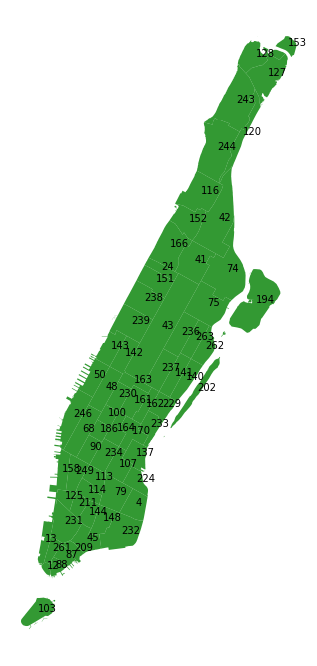

In [60]:


figsize = 20,12

fig,ax = plt.subplots(figsize=figsize)

Location_shape.plot(color='g',ax=ax,alpha=0.8)


'''Mark the Location ID'''
for idx,row in Location_shape.iterrows():

    ax.annotate(s=row['LocationID'],fontsize=10,xy=Location_Center_dic[row['LocationID']])
    
    
'''Turn off the axis'''
plt.xticks([])  
plt.yticks([])  
plt.axis('off')  


plt.show()



# State and Action

In [62]:
End_step=144

State=np.array([],dtype='str')

for loc in Location_list:
    
    for step in range(End_step):
        
        state=str(loc)+'-'+str(step)
        
        if state in State:
            
            print(state)
        
        State=np.append(State,state)
        
        
        
np.save('./Data/Processed/State.npy',State)

Action={}
i=0
for loc in Location_list:
    
    idx=Location_ID_dic_reverse[loc]
    
    action_idx=np.argwhere(Connect_matrix[idx]==1.0).flatten()
    
    action=[Location_ID_dic[_] for _ in action_idx]
    
    for step in range(End_step):
        
        state=str(loc)+'-'+str(step)
    
        Action[state]=action


np.save('./Data/Processed/Action.npy',Action)
    

# Request data

In [63]:
stamp_transition=Stamp_transition()

Request_data=pd.read_csv('./Data/Source/yellow_tripdata_2019-12.csv')

Request_data=Request_data[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','fare_amount']]

Request_data.columns =['Pickup_Location','Dropoff_Location','Pickup_time','Dropoff_time','Reward_unit']

'''Location filtering'''

Location_range=Location_shape[['LocationID']]

Request_data=Request_data.merge(Location_range,left_on='Pickup_Location',right_on='LocationID')

Request_data=Request_data[['Pickup_Location','Dropoff_Location','Pickup_time','Dropoff_time','Reward_unit']]

Request_data=Request_data.merge(Location_range,left_on='Dropoff_Location',right_on='LocationID')

Request_data=Request_data[['Pickup_Location','Dropoff_Location','Pickup_time','Dropoff_time','Reward_unit']]

'''Time filtering'''

Request_data['Pickup_Date']=Request_data.apply(lambda x:x['Pickup_time'][:10],axis=1)

Request_data['Dropoff_Date']=Request_data.apply(lambda x:x['Dropoff_time'][:10],axis=1)

Request_data['Pickup_step']=Request_data.apply(lambda x:stamp_transition.Get_step(stamp_transition.Get_stamp(x['Pickup_time']),x['Pickup_Date'],600),axis=1)

Request_data['Dropoff_step']=Request_data.apply(lambda x:stamp_transition.Get_step(stamp_transition.Get_stamp(x['Dropoff_time']),x['Dropoff_Date'],600),axis=1)

Request_data=Request_data[['Pickup_Location','Dropoff_Location','Pickup_step','Dropoff_step','Reward_unit']]

# Request_data.to_csv('./Data/Processed/Request_data.csv')


# Average Reward Unit and Order Quantity 

In [77]:
Request_data=pd.read_csv('./Data/Processed/Request_data.csv')

Request_data=Request_data.drop(columns=['Unnamed: 0'])

'''Average Reward Unit'''

Reward_table=Request_data.groupby(['Pickup_Location','Pickup_step']).mean()[['Reward_unit']]

Reward_table['Transition']=Reward_table.index

Reward_table['Pickup_Location']=Reward_table.apply(lambda x:x['Transition'][0],axis=1)

Reward_table['Pickup_step']=Reward_table.apply(lambda x:x['Transition'][1],axis=1)

Reward_table=Reward_table.reset_index(drop=True)

Reward_table['Pickup_state']=Reward_table.apply(lambda x:str(x['Pickup_Location'])+'-'+str(x['Pickup_step']),axis=1)

Reward_table=Reward_table[['Pickup_state','Reward_unit']]

Reward_table

Reward_dic={state:0.0 for state in State}

for idx,row in Reward_table.iterrows():
    
    state=row['Pickup_state']
    
    Reward_dic[state]=row['Reward_unit']
    
'''Request_count table'''

Request_count=Request_data.groupby(['Pickup_Location','Pickup_step']).count()[['Reward_unit']]

Request_count['Transition']=Request_count.index

Request_count['Pickup_Location']=Request_count.apply(lambda x:x['Transition'][0],axis=1)

Request_count['Pickup_step']=Request_count.apply(lambda x:x['Transition'][1],axis=1)

Request_count=Request_count.reset_index(drop=True)

Request_count['Pickup_state']=Request_count.apply(lambda x:str(x['Pickup_Location'])+'-'+str(x['Pickup_step']),axis=1)

Request_count=Request_count.rename(index=str, columns={'Reward_unit': 'Order_Cnt'})

Request_count['Order_Cnt']=Request_count.apply(lambda x:round(x['Order_Cnt']/31.0,2),axis=1)

Request_count=Request_count[['Pickup_state','Order_Cnt']]

Capacity_dic={state:0.0 for state in State}

for idx,row in Request_count.iterrows():
    
    state=row['Pickup_state']
    
    Capacity_dic[state]=row['Order_Cnt']
    

np.save('./Data/Processed/Reward_dic.npy',Reward_dic)

np.save('./Data/Processed/Capacity_dic.npy',Capacity_dic)


# Destination distribution

In [119]:
'''service speed = 5 km /10 min'''

speed=5.0

'''Request Distribution'''

Request_PROB=Request_data.groupby(['Pickup_Location','Pickup_step','Dropoff_Location']).count()[['Reward_unit']]

Request_PROB['Transition']=Request_PROB.index

Request_PROB['Pickup_Location']=Request_PROB.apply(lambda x:x['Transition'][0],axis=1)

Request_PROB['Pickup_step']=Request_PROB.apply(lambda x:x['Transition'][1],axis=1)

Request_PROB['Dropoff_Location']=Request_PROB.apply(lambda x:x['Transition'][2],axis=1)

Request_PROB=Request_PROB.reset_index(drop=True)

Request_PROB=Request_PROB.rename(index=str, columns={"Reward_unit": "Order_Cnt"})

Request_PROB=Request_PROB[['Pickup_Location','Pickup_step','Dropoff_Location','Order_Cnt']]

Request_PROB


TEMP=Request_data.groupby(['Pickup_Location','Pickup_step']).count()[['Reward_unit']]

TEMP['Transition']=TEMP.index

TEMP['Pickup_Location']=TEMP.apply(lambda x:x['Transition'][0],axis=1)

TEMP['Pickup_step']=TEMP.apply(lambda x:x['Transition'][1],axis=1)

TEMP=TEMP.rename(index=str, columns={"Reward_unit": "Order_Sum"})

TEMP=TEMP.reset_index(drop=True)

TEMP=TEMP[['Pickup_Location','Pickup_step','Order_Sum']]

Request_PROB=Request_PROB.merge(TEMP,on=['Pickup_Location','Pickup_step'])

Request_PROB['Prob']=Request_PROB.apply(lambda x:round(float(x['Order_Cnt']/x['Order_Sum']),2),axis=1)

Request_PROB=Request_PROB[['Pickup_Location','Pickup_step','Dropoff_Location','Prob']]

Get_Travel_time=lambda loc1,loc2:int(np.ceil(Network_Distance[Location_ID_dic_reverse[loc1]][Location_ID_dic_reverse[loc2]]/speed))

Request_PROB['Dropoff_step']=Request_PROB.apply(lambda x:Get_Travel_time(x['Pickup_Location'],x['Dropoff_Location']),axis=1)

Request_PROB=Request_PROB[['Pickup_Location','Pickup_step','Dropoff_Location','Dropoff_step','Prob']].astype('int32')

Request_PROB['Pickup_state']=Request_PROB.apply(lambda x:str(x['Pickup_Location'])+'-'+str(x['Pickup_step']),axis=1)

Request_PROB['Dropoff_state']=Request_PROB.apply(lambda x:str(x['Dropoff_Location'])+'-'+str(x['Dropoff_step']),axis=1)

Request_PROB['Dropoff_state']=Request_PROB.apply(lambda x:str(x['Dropoff_Location'])+'-'+str(x['Dropoff_step']),axis=1)

Request_PROB=Request_PROB[['Pickup_state','Dropoff_state','Prob']]

Request_PROB_Dic={}

for idx,row in Request_PROB.iterrows():
    
    if row['Pickup_state'] not in Request_PROB_Dic.keys():
    
        Request_PROB_Dic[row['Pickup_state']]={}
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        
    else:
        
        Request_PROB_Dic[row['Pickup_state']][row['Dropoff_state']]=row['Prob']
        
np.save('./Data/Processed/Request_PROB_Dic.npy',Request_PROB_Dic)

Request_PROB_Dic                        
